# Classification with HDF5 data

In this example we'll use Caffe to do simple logistic regression on a simple binary dataset, showcasing HDF5DataLayer functionality.

In [2]:
import os
import h5py
import shutil
import sklearn
import tempfile
import numpy as np
import pandas as pd
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
X, y = sklearn.datasets.make_classification(
    n_samples=10000, n_features=4, n_redundant=0, n_informative=2, 
    n_clusters_per_class=2, hypercube=False, random_state=0
)

# Split into train and test
X, Xt, y, yt = sklearn.cross_validation.train_test_split(X, y)

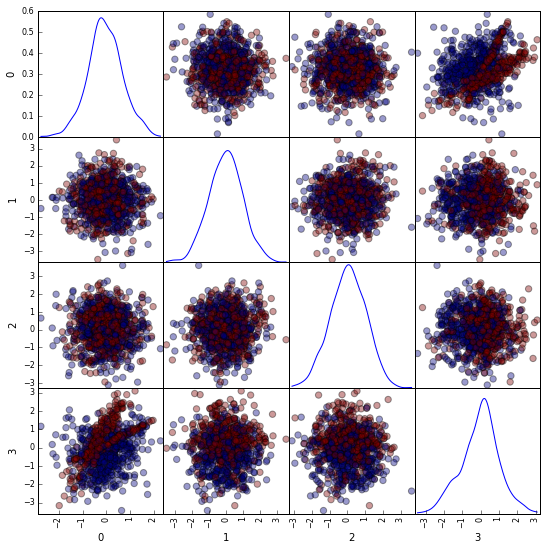

In [4]:
# Visualize sample of the data
ind = np.random.permutation(X.shape[0])[:1000]
df = pd.DataFrame(X[ind])
_ = pd.scatter_matrix(df, figsize=(9, 9), diagonal='kde', marker='o', s=40, alpha=.4, c=y[ind])

In [5]:
# Train and test the scikit-learn SGD logistic regression.
clf = sklearn.linear_model.SGDClassifier(
    loss='log', n_iter=1000, penalty='l2', alpha=1e-3, class_weight='auto')

clf.fit(X, y)
yt_pred = clf.predict(Xt)
print('Accuracy: {:.3f}'.format(sklearn.metrics.accuracy_score(yt, yt_pred)))

Accuracy: 0.776


In [6]:
# Write out the data to HDF5 files in a temp directory.
# This file is assumed to be caffe_root/examples/hdf5_classification.ipynb
dirname = os.path.abspath('./hdf5_classification/data')
if not os.path.exists(dirname):
    os.makedirs(dirname)

train_filename = os.path.join(dirname, 'train.h5')
test_filename = os.path.join(dirname, 'test.h5')

# HDF5DataLayer source should be a file containing a list of HDF5 filenames.
# To show this off, we'll list the same data file twice.
with h5py.File(train_filename, 'w') as f:
    f['data'] = X
    f['label'] = y.astype(np.float32)
with open(os.path.join(dirname, 'train.txt'), 'w') as f:
    f.write(train_filename + '\n')
    f.write(train_filename + '\n')
    
# HDF5 is pretty efficient, but can be further compressed.
comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
with h5py.File(test_filename, 'w') as f:
    f.create_dataset('data', data=Xt, **comp_kwargs)
    f.create_dataset('label', data=yt.astype(np.float32), **comp_kwargs)
with open(os.path.join(dirname, 'test.txt'), 'w') as f:
    f.write(test_filename + '\n')

In [7]:
# Run caffe. Scroll down in the output to see the final
# test accuracy, which should be about the same as above.
!cd .. && ./build/tools/caffe train -solver examples/hdf5_classification/solver.prototxt

/bin/sh: ./build/tools/caffe: No such file or directory


If you look at the `train_val.prototxt`, you'll see that it's simple logistic regression.
We can make it a little more advanced by introducing a non-linearity between weights that take the input and weights that give the output -- now we have a two-layer neural network.
That network is given in `train_val2.prototxt`, and that's the only change made in `solver2.prototxt` which we will now use.

The final accuracy of the network we'll train below should be higher than for the network above!

In [7]:
!cd .. && ./build/tools/caffe train -solver examples/hdf5_classification/solver2.prototxt

I0905 01:07:27.466722 2129298192 caffe.cpp:90] Starting Optimization
I0905 01:07:27.468166 2129298192 solver.cpp:32] Initializing solver from parameters: 
test_iter: 1000
test_interval: 1000
base_lr: 0.01
display: 1000
max_iter: 10000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 5000
snapshot: 10000
snapshot_prefix: "examples/hdf5_classification/data/train"
solver_mode: CPU
net: "examples/hdf5_classification/train_val2.prototxt"
I0905 01:07:27.468351 2129298192 solver.cpp:72] Creating training net from net file: examples/hdf5_classification/train_val2.prototxt
I0905 01:07:27.469081 2129298192 net.cpp:275] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0905 01:07:27.469100 2129298192 net.cpp:275] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0905 01:07:27.469110 2129298192 net.cpp:39] Initializing net from parameters: 
name: "LogisticRegressionNet"
layers {
  top: "data"
  top

In [8]:
# Clean up (comment this out if you want to examine the hdf5_classification/data directory).
shutil.rmtree(dirname)